In [ ]:
#import utilities
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm.notebook import tqdm
import pandas as pd

# Dataset

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device available is: {device}")


batch_size = 128
lr = 1e-3
num_epochs = 50

Device available is: cuda


In [ ]:
class VAE(nn.Module):
    def __init__(self, imgChannels = 1, featureDim = 32*20*20, zDim = 256):
        super(VAE, self).__init__()

        #Encoder
        self.En_Conv1 = nn.Conv2d(imgChannels, 16, 5)
        self.En_Conv2 = nn.Conv2d(16, 32, 5)
        self.En_fc1 = nn.Linear(featureDim, zDim)
        self.En_fc2 = nn.Linear(featureDim, zDim)

        #Decoder
        self.De_FC1 = nn.Linear(zDim, featureDim)
        self.Dec_ConvT1 = nn.ConvTranspose2d(32, 16, 5)
        self.Dec_ConvT2 = nn.ConvTranspose2d(16, imgChannels, 5)

    def encoder(self, x):

        x = F.relu(self.En_Conv1(x))
        x = F.relu(self.En_Conv2(x))
        x = x.view(-1, 32*20*20)

        mu = self.En_fc1(x)
        logVar = self.En_fc2(x)

        return mu, logVar

    def reparametrization(self, mu, logVar):

        std = torch.exp(logVar/2)
        eps = torch.rand_like(std)

        return mu + (eps*std)     

    def decoder(self, z):
        z = F.relu(self.De_FC1(z))
        z = z.view(-1, 32,20,20)
        z = F.relu(self.Dec_ConvT1(z))
        z = F.sigmoid(self.Dec_ConvT2(z))

        # z = torch.sigmoid(self.Dec_ConvT2(z))

        return z

    def forward(self, x:torch.Tensor):

        mu, logVar = self.encoder(x)
        z = self.reparametrization(mu, logVar)
        out = self.decoder(z)

        return out, z, mu, logVar

In [ ]:
train_loader = torch.utils.data.DataLoader(datasets.MNIST('data', train = True, download = True, transform= transforms.ToTensor()), batch_size= batch_size)
test_loader = torch.utils.data.DataLoader(datasets.MNIST('data', train = False, transform= transforms.ToTensor()), batch_size= batch_size)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# KLD Loss

In [ ]:
class KLD_Loss(nn.Module):
    def __init__(self, weight: float = 1.):
        super(KLD_Loss, self).__init__()
        self.weight = weight

    def forward(self, output_mu, output_logVar):
        batch_size = output_mu.size(0)
        # output_mu = output_mu
        # output_logVar = output_logVar
        
        KL_loss = 0.5* (torch.sum(-1 - output_logVar + torch.pow(output_mu, 2) + torch.exp(output_logVar)))
        return self.weight * KL_loss

# Training Model

In [ ]:
#Initialize the model, optimizer, loss functions
net = VAE().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr = lr)
bce_criterion = nn.BCELoss(reduction = "sum").to(device)
kld_criterion = KLD_Loss().to(device)

In [ ]:
track_dict = {
        "Epoch": [],
        "Tr_BCE_Loss": [],
        "Tr_KLD_Loss": [],
        "Training_Loss": [],
        "Test_Loss": []
            }

In [ ]:
def train(model, train_loader, device, epoch_id, track_dict, n_epochs):
    model.train()
    training_loss = 0
    training_bce = 0
    training_kld = 0

    for data in tqdm(train_loader):
        optimizer.zero_grad()

        #Getting the data from the trainloader
        imgs, _ = data
        imgs = imgs.to(device)

        #Forward Propagation
        out, z, mu, logVar = model(imgs)
        bce_loss = bce_criterion(out, imgs)
        kl_loss = kld_criterion(mu, logVar)

        loss = bce_loss + kl_loss

        #Backward Propagation
        loss.backward()
        optimizer.step()

        #Getting the losses
        training_loss += loss.item()
        training_bce += bce_loss.item()
        training_kld += kl_loss.item()

    training_loss /= len(train_loader.dataset)
    training_bce /= len(train_loader.dataset)
    training_kld /= len(train_loader.dataset)

    #Updating the tracker
    track_dict["Epoch"].append(epoch_id)
    track_dict["Tr_BCE_Loss"].append(training_bce)
    track_dict["Tr_KLD_Loss"].append(training_kld)
    track_dict["Training_Loss"].append(training_loss)

    print("Epoch {}/{}: Training Loss is {:.6f}".format(epoch_id, n_epochs, training_loss))

In [ ]:
def test(model, test_loader, device, epoch_id, track_dict, n_epochs):
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for data in tqdm(test_loader):
            #getting the data
            imgs, _ = data
            imgs = imgs.to(device)   

            #Forward Propagation
            out, z, mu, logVar = model(imgs)
            bce_loss = bce_criterion(out, imgs)
            kl_loss = kld_criterion(mu, logVar)           

            loss = bce_loss + kl_loss
            
            test_loss += loss.item()
        
    test_loss /= len(test_loader.dataset)

    #Updating the tracker
    track_dict["Test_Loss"].append(test_loss) 
    
    print("Epoch {}/{}: Test Loss is {:.6f}".format(epoch_id, n_epochs, test_loss))

In [ ]:
for epoch in range(1, num_epochs+1):
    train(net, train_loader, device, epoch, track_dict, num_epochs)
    test(net, test_loader, device, epoch, track_dict, num_epochs)

    if epoch % 5 == 0 :
        df = pd.DataFrame(track_dict).to_csv("summary.csv")

    if epoch % 10 == 0:
        torch.save(net.state_dict(), "VAE_" + str(epoch) + "_epoch.pth")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



Epoch 1/50: Training Loss is 120.224425



Epoch 1/50: Test Loss is 87.860335



Epoch 2/50: Training Loss is 83.919777



Epoch 2/50: Test Loss is 81.755848



Epoch 3/50: Training Loss is 80.827552



Epoch 3/50: Test Loss is 79.881462



Epoch 4/50: Training Loss is 79.202857



Epoch 4/50: Test Loss is 78.563385



Epoch 5/50: Training Loss is 78.152206



Epoch 5/50: Test Loss is 78.620877



Epoch 6/50: Training Loss is 77.362448



Epoch 6/50: Test Loss is 77.386645



Epoch 7/50: Training Loss is 76.659472



Epoch 7/50: Test Loss is 76.152130



Epoch 8/50: Training Loss is 76.023772



Epoch 8/50: Test Loss is 75.816847



Epoch 9/50: Training Loss is 75.528985



Epoch 9/50: Test Loss is 75.411891



Epoch 10/50: Training Loss is 75.104904



Epoch 10/50: Test Loss is 75.273181



Epoch 11/50: Training Loss is 74.717358



Epoch 11/50: Test Loss is 74.998038



Epoch 12/50: Training Loss is 74.346945



Epoch 12/50: Test Loss is 74.187365



Epoch 13/50: Training Loss is 74.083833



Epoch 13/50: Test Loss is 73.935860



Epoch 14/50: Training Loss is 73.761400



Epoch 14/50: Test Loss is 73.949591



Epoch 15/50: Training Loss is 73.492432



Epoch 15/50: Test Loss is 73.442845



Epoch 16/50: Training Loss is 73.311347



Epoch 16/50: Test Loss is 73.198820



Epoch 17/50: Training Loss is 73.096197



Epoch 17/50: Test Loss is 73.236471



Epoch 18/50: Training Loss is 72.912051



Epoch 18/50: Test Loss is 72.739690



Epoch 19/50: Training Loss is 72.735860



Epoch 19/50: Test Loss is 72.630182



Epoch 20/50: Training Loss is 72.544018



Epoch 20/50: Test Loss is 72.447105



Epoch 21/50: Training Loss is 72.284796



Epoch 21/50: Test Loss is 72.372309



Epoch 22/50: Training Loss is 72.152381



Epoch 22/50: Test Loss is 72.262062



Epoch 23/50: Training Loss is 71.990008



Epoch 23/50: Test Loss is 71.960724



Epoch 24/50: Training Loss is 71.899890



Epoch 24/50: Test Loss is 71.872938



Epoch 25/50: Training Loss is 71.675201



Epoch 25/50: Test Loss is 71.948032



Epoch 26/50: Training Loss is 71.629694



Epoch 26/50: Test Loss is 71.653308



Epoch 27/50: Training Loss is 71.466325



Epoch 27/50: Test Loss is 71.764531



Epoch 28/50: Training Loss is 71.391934



Epoch 28/50: Test Loss is 71.576906



Epoch 29/50: Training Loss is 71.262839



Epoch 29/50: Test Loss is 71.356692



Epoch 30/50: Training Loss is 71.211114



Epoch 30/50: Test Loss is 71.214154



Epoch 31/50: Training Loss is 71.108710



Epoch 31/50: Test Loss is 71.242918



Epoch 32/50: Training Loss is 70.942750



Epoch 32/50: Test Loss is 71.177322



Epoch 33/50: Training Loss is 70.867460



Epoch 33/50: Test Loss is 71.186293



Epoch 34/50: Training Loss is 70.815768



Epoch 34/50: Test Loss is 71.146328



Epoch 35/50: Training Loss is 70.772915



Epoch 35/50: Test Loss is 71.249882



Epoch 36/50: Training Loss is 70.656924



Epoch 36/50: Test Loss is 70.974690



Epoch 37/50: Training Loss is 70.625303



Epoch 37/50: Test Loss is 70.747511



Epoch 38/50: Training Loss is 70.540594



Epoch 38/50: Test Loss is 70.769617



Epoch 39/50: Training Loss is 70.476662



Epoch 39/50: Test Loss is 70.621066



Epoch 40/50: Training Loss is 70.470403



Epoch 40/50: Test Loss is 70.535341



Epoch 41/50: Training Loss is 70.350387



Epoch 41/50: Test Loss is 70.676006



Epoch 42/50: Training Loss is 70.284296



Epoch 42/50: Test Loss is 70.584957



Epoch 43/50: Training Loss is 70.285691



Epoch 43/50: Test Loss is 70.499131



Epoch 44/50: Training Loss is 70.211484



Epoch 44/50: Test Loss is 70.447784



Epoch 45/50: Training Loss is 70.180564



Epoch 45/50: Test Loss is 70.528082



Epoch 46/50: Training Loss is 70.127272



Epoch 46/50: Test Loss is 70.350445



Epoch 47/50: Training Loss is 70.060463



Epoch 47/50: Test Loss is 70.537733



Epoch 48/50: Training Loss is 69.976855



Epoch 48/50: Test Loss is 70.379904



Epoch 49/50: Training Loss is 69.963219



Epoch 49/50: Test Loss is 70.257510



Epoch 50/50: Training Loss is 69.939853



Epoch 50/50: Test Loss is 70.225098


# Plots

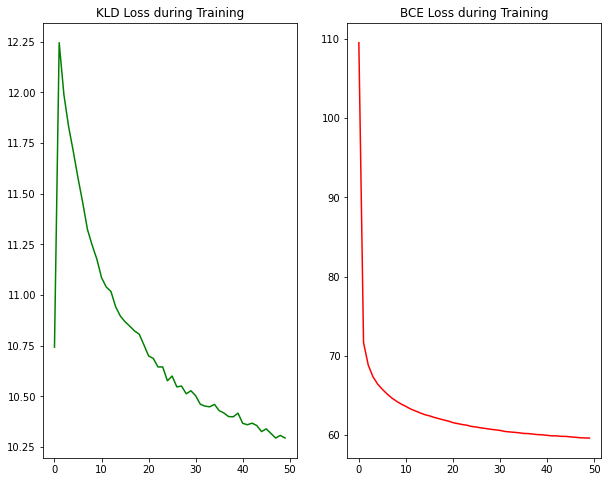

In [ ]:
plt.figure(figsize = (10,8))
plt.subplot(1,2,1)
plt.title("KLD Loss during Training")
plt.plot(track_dict["Tr_KLD_Loss"], color = "green")
plt.subplot(1,2,2)
plt.title("BCE Loss during Training")
plt.plot(track_dict["Tr_BCE_Loss"], color = "red")
plt.show()

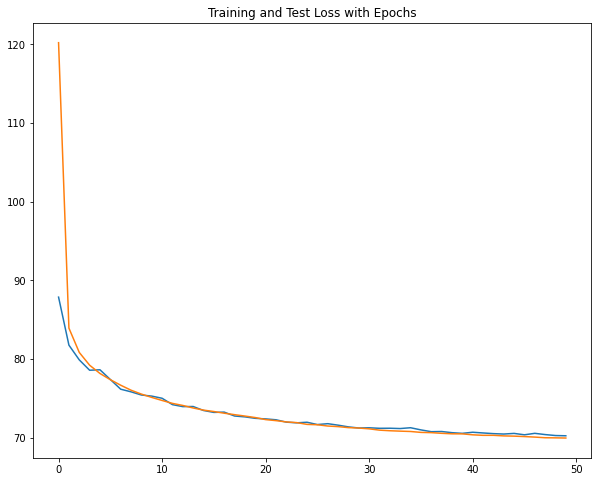

In [ ]:
plt.figure(figsize = (10,8))
plt.title("Training and Test Loss with Epochs")
plt.plot(track_dict["Test_Loss"])
plt.plot(track_dict["Training_Loss"])
plt.show()

# Test Time

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VAE().to(device)
model.load_state_dict(torch.load("/content/VAE_50_epoch.pth"), strict = True)
print(f"Available device is {device}")

Available device is cuda


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


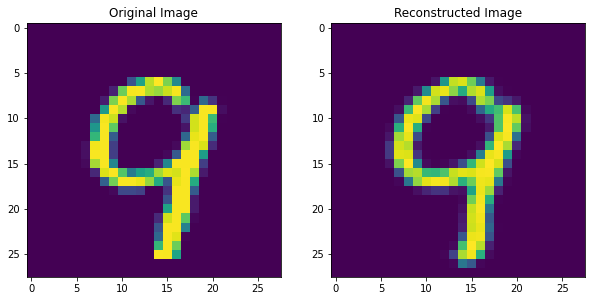

In [ ]:
#Generating random images from the Test Dataset and Visualizing the resconstruction

index = random.randint(0, batch_size-1)

model.eval()
with torch.no_grad():
    for data in test_loader:
        imgs, _ = data

        #Getting one image from the list
        img = imgs[index].unsqueeze(0).to(device)
        out, z, mu, logVar = model(img)

        img = img.squeeze(0).permute(1,2,0).to("cpu")
        out = out.squeeze(0).permute(1,2,0).to("cpu")
        

        plt.figure(figsize = (10,8))
        plt.subplot(1,2,1)
        plt.title("Original Image")
        plt.imshow(np.squeeze(img))
        plt.subplot(1,2,2)
        plt.title("Reconstructed Image")
        plt.imshow(np.squeeze(out))
        plt.show()
        break

# Visualizing the Latent Space

### Getting the hidden representation

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = VAE().to(device)
# model.load_state_dict(torch.load("/content/VAE_50_epoch.pth"), strict = True)
# print(f"Available device is {device}")

In [ ]:
#Getting the hidden representation of the data

my_data = []
my_labels = []

model.eval()

with torch.no_grad():
    for img, label in test_loader:
        img, label = img.to(device), label.to(device)

        #Feedforward through the model
        out, z, mu, logVar = model(img)
        z = z.to("cpu").numpy()
        label = label.to("cpu").numpy()

        #Appending to the list
        my_data.append(z)
        my_labels.append(label)

print("Tasks done succesfully!")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Tasks done succesfully!


In [ ]:
data_X = np.concatenate(my_data)
print("Shape of data_X is: ", data_X.shape)

data_y = np.concatenate(my_labels)
print("Shape of data_y is: ", data_y.shape)

Shape of data_X is:  (10000, 256)
Shape of data_y is:  (10000,)


### T_SNE for visualization

In [ ]:
from sklearn.manifold import TSNE
seed = 101

tsne = TSNE(n_components=2, random_state= seed)
transformed_data_X = tsne.fit_transform(data_X)

In [ ]:
print("Shape of the transformed data is: ", transformed_data_X.shape)

Shape of the transformed data is:  (10000, 2)


In [ ]:
#Saving the transformed data for future uses

transformed_data_X_df = pd.DataFrame(transformed_data_X, columns = ["Feature1", "Feature2"])
transformed_data_X_df["Labels"] = data_y

transformed_data_X_df.to_csv("Transformed_Test_Data.csv")

In [ ]:
def TSNE_plot(X1, X2, targets, title):
    '''
    X1: Numpy array
    X2: Numpy array
    targets: Array containing the labels
    title: Plot heading
    '''
    plt.figure(figsize= (10,8))
    sns.scatterplot(x = X1, y = X2, hue = targets, palette = "Set1")
    plt.title("T-SNE decomposition of the data")
    plt.show()

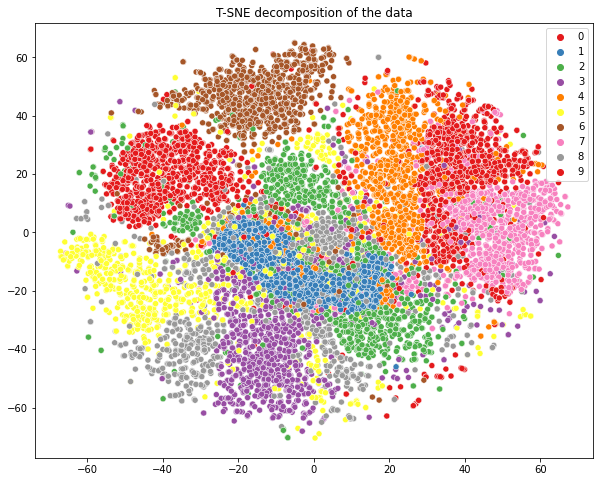

In [ ]:
#Getting the plot
TSNE_plot(transformed_data_X[:,0], transformed_data_X[:,1], data_y, "T-SNE plot of the enocoded data")